In [64]:
import sys, importlib
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import time
from collections import OrderedDict
import optuna
import os
import joblib
import torch.optim as optim


sys.path.append("../")
from proj_mod import training, data_processing, visualization, param_optim, io_utils, model_io
importlib.reload(training);
importlib.reload(data_processing);
importlib.reload(visualization);
importlib.reload(param_optim);
importlib.reload(io_utils);
importlib.reload(model_io);

device=(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Using device {device}")

Using device cuda


In [2]:
# Dataset creation
list_time=np.load("../processed_data/recovered_time_id_order.npy")
df_RV_ts=pd.read_parquet("../processed_data/book_RV_ts_60_si.parquet")

df_target=pd.read_csv("../raw_data/kaggle_ORVP/train.csv")
df_target["row_id"]=df_target["stock_id"].astype(int).astype(str)+"-"+df_target["time_id"].astype(int).astype(str)

with io_utils.suppress_output():
    time_split_list=data_processing.time_cross_val_split(list_time=list_time,n_split=1,percent_val_size=10,list_output=True);
    train_time_id,test_time_id=time_split_list[0][0],time_split_list[0][1]
    
    train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_target=df_target)
    test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_target=df_target)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

# Encoder decoder without id

In [3]:
# Model definition with parameters. DO NOT CHANGE if you want to be able to load weights and use the model for inference.

def define_model_encdec(trial):

    # === Hyperparameters (Optuna) ===
    encoder_layers = trial.suggest_int("encoder_layer_num", 2, 4)
    decoder_layers = trial.suggest_int("decoder_layer_num", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.3, step=0.1)   
    ff_dim = trial.suggest_categorical("ff_dim", [48, 64, 96])
    
    
    ts_emb_dim=32
    n_diff=2
    ts_dim=n_diff+1
    
    pos_embedder=training.pos_emb_cross_attn(length=60,
                                             ts_dim=ts_dim,
                                             emb_dim=ts_emb_dim,
                                             dropout=0.2,
                                             num_heads=4,
                                             keep_mag=True).to(device=device)
    ts_encoder_ff_layer=[
        nn.Linear(in_features=ts_emb_dim,out_features=ff_dim),
        nn.ReLU(),
        nn.Linear(in_features=ff_dim,out_features=ts_emb_dim)
    ]
    
    ts_decoder_ff_layer=[
        nn.Linear(in_features=ts_emb_dim,out_features=ff_dim),
        nn.ReLU(),
        nn.Linear(in_features=ff_dim,out_features=ts_emb_dim)
    ]
    
    output_ff=nn.Sequential(
        nn.Linear(in_features=ts_emb_dim,out_features=1)
    ).to(device=device)


    return training.encoder_decoder_teacherforcing(
        pos_emb_model=pos_embedder,
        output_feedforward=output_ff,
        encoder_dropout=dropout,
        decoder_dropout=dropout,
        encoder_feedforward_list=ts_encoder_ff_layer,
        decoder_feedforward_list=ts_decoder_ff_layer,
        n_diff=n_diff,
        encoder_layer_num=encoder_layers,
        decoder_layer_num=decoder_layers,
        input_scaler=10000,
        ts_emb_dim=ts_emb_dim,
        encoder_num_heads=4,
        decoder_num_heads=4,
        encoder_keep_mag=True,
        decoder_keep_mag=True,
        return_sum=True
    )

In [4]:
# Study creation and execution
study_encdec = optuna.create_study(direction="minimize",
                                   pruner=optuna.pruners.NopPruner()
                                  )

study_encdec.optimize(lambda trial: param_optim.objective(trial,
                                                          define_model_encdec,
                                                          train_loader,
                                                          test_loader,
                                                          device
                                                         ), n_trials=30)

[I 2025-08-09 00:31:12,011] A new study created in memory with name: no-name-77077dba-5fe5-4dcc-909d-e4c5e4c4f00e
[I 2025-08-09 00:37:32,553] Trial 0 finished with value: 0.23280201852321625 and parameters: {'lr': 3.311089318821631e-05, 'encoder_layer_num': 4, 'decoder_layer_num': 3, 'dropout': 0.2, 'ff_dim': 64}. Best is trial 0 with value: 0.23280201852321625.
[I 2025-08-09 00:43:48,489] Trial 1 finished with value: 0.23121465742588043 and parameters: {'lr': 8.980047923943808e-05, 'encoder_layer_num': 4, 'decoder_layer_num': 3, 'dropout': 0.1, 'ff_dim': 48}. Best is trial 1 with value: 0.23121465742588043.
[I 2025-08-09 00:49:03,877] Trial 2 finished with value: 0.23075662553310394 and parameters: {'lr': 0.0013130035738772407, 'encoder_layer_num': 4, 'decoder_layer_num': 2, 'dropout': 0.2, 'ff_dim': 64}. Best is trial 2 with value: 0.23075662553310394.
[I 2025-08-09 00:55:18,925] Trial 3 finished with value: 0.23467107117176056 and parameters: {'lr': 1.841270334402454e-05, 'encoder_l

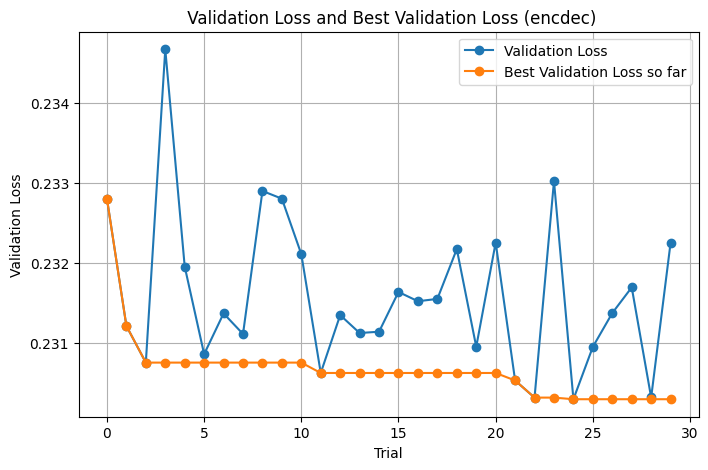

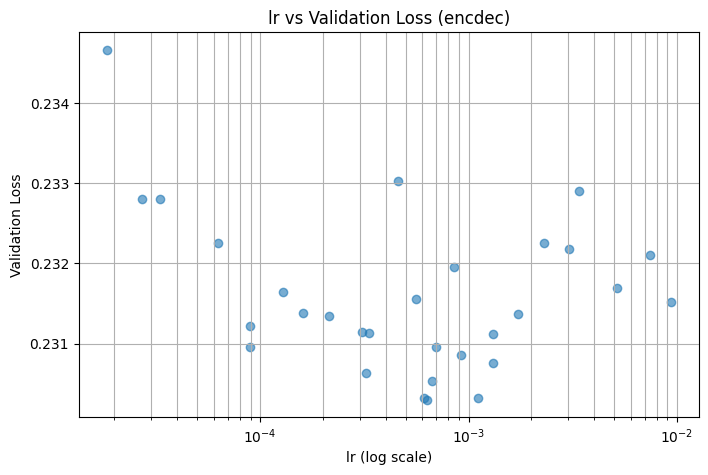

In [66]:
visualization.study_plots(study_encdec, title_prefix="encdec")

The first plot above looks like a typical optimization history plot. Big spikes indicate that Optuna tries new regions for the sampling, 

The second plot can help us determine regions where the validation loss tends to be smaller.

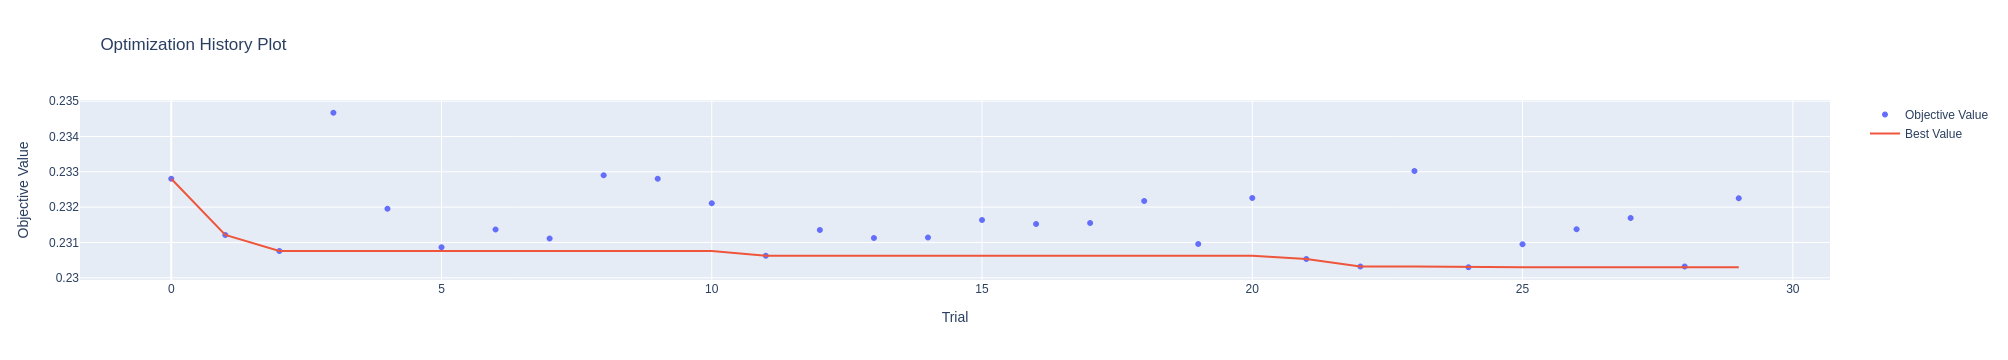

In [68]:
# I didn't know optuna had a similar function before constructing mine, lol

from plotly.io import show
fig = optuna.visualization.plot_optimization_history(study_encdec)
show(fig)

In [9]:
# Training using optimal hyperparameters

best_trial_encdec = study_encdec.best_trial
model_encdec = define_model_encdec(optuna.trial.FixedTrial(best_trial_encdec.params)).to(device)

atts_encdec = study_encdec.best_trial.user_attrs

optimizer = torch.optim.AdamW(model_encdec.parameters(), 
                              lr=best_trial_encdec.params["lr"])


scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode="min",factor=0.5,patience=5,min_lr=1e-7)


train_loss = []
val_loss = []

encdec_best_weights=training.reg_training_loop_rmspe(
    optimizer=optimizer,
    model=model_encdec,
    train_loader=train_loader,
    val_loader=test_loader,
    ot_steps=20,
    report_interval=5,
    n_epochs=200,
    list_train_loss=train_loss,
    list_val_loss=val_loss,
    device=device,
    eps=1e-8,
    scheduler=scheduler)

A new best validation loss at epoch  1  with validation loss of  tensor(0.2639, device='cuda:0') .
At  27.077584743499756  epoch  1 has training loss  tensor(0.2761, device='cuda:0')  and validation loss  tensor(0.2639, device='cuda:0') .

A new best validation loss at epoch  2  with validation loss of  tensor(0.2341, device='cuda:0') .
A new best validation loss at epoch  3  with validation loss of  tensor(0.2319, device='cuda:0') .
At  142.36074423789978  epoch  5 has training loss  tensor(0.2490, device='cuda:0')  and validation loss  tensor(0.2346, device='cuda:0') .

A new best validation loss at epoch  7  with validation loss of  tensor(0.2312, device='cuda:0') .
At  283.5200116634369  epoch  10 has training loss  tensor(0.2478, device='cuda:0')  and validation loss  tensor(0.2312, device='cuda:0') .

At epoch 13, learning rate has been updated from 0.0006303982745144811 to 0.00031519913725724057, reloading previous best model weights from epoch 7 ...

Previous best model weights

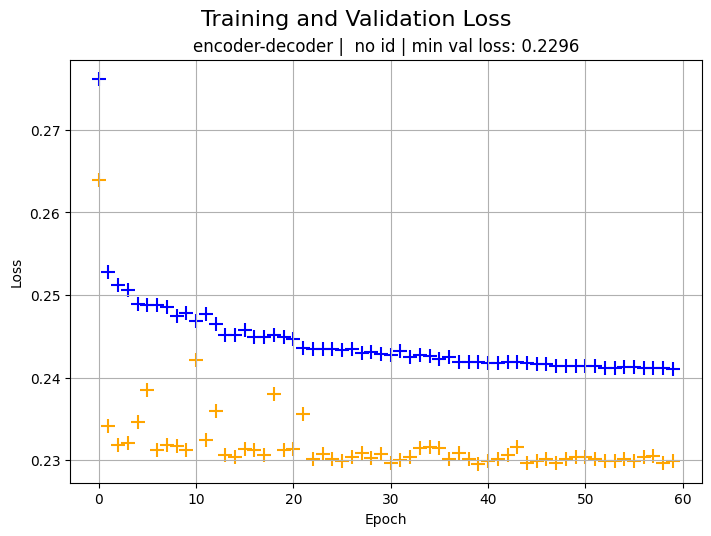

In [36]:
# Plot loss after training and saves plot
vis_dict={("encoder-decoder","no id"):{"train_loss": train_loss,"val_loss": val_loss}}
visualization.training_plots(vis_dict, fig_width=7, save_path=save_dir+"encdec_loss.png")

In [11]:
# Save model weights and study
model_io.save_model_and_study(
    model_encdec,
    study_encdec,
    save_dir="../model_data/Encoder_decoder",
    weights_filename="encdec_best_weights.pth",
    study_filename="encdec_study.pkl"
)

In [31]:
# Reconstructs the trained model
model_encdec_loaded, study_endec_loaded = model_io.load_model_and_study(
    define_model_encdec,
    device,
    save_dir="../model_data/Encoder_decoder",
    weights_filename="encdec_best_weights.pth",
    study_filename="encdec_study.pkl"
)

In [32]:
# Checks structures are the same
print(str(model_encdec) == str(model_encdec_loaded))

True


In [33]:
# Checks weights are the same
same_weights = all(torch.equal(a, b) 
                   for a, b in zip(model_encdec.state_dict().values(),
                                   model_encdec_loaded.state_dict().values()))
print(same_weights)

True


In [49]:
# We also need to save train_loss and val_loss if we want to be able to reproduce the plot for train and validation loss

torch.save((train_loss, val_loss), "../model_data/Encoder_decoder/encdec_loss.pt")

# train_lossr, val_lossr = torch.load( "../model_data/Encoder_decoder/encdec_loss.pt")
# vis_dict={("encoder-decoder","no id"):{"train_loss": train_lossr,"val_loss": val_lossr}}
# visualization.training_plots(vis_dict, fig_width=7, save_path=save_dir+"encdec_loss.png")

# Encoder decoder with id

In [41]:
# Dataset creation. Some of the dataframes were created above. This is just the data that's missing for this model.
RV_tab=pd.read_csv("../processed_data/RV_by_row_id.csv")
RV_tab["stock_id"]=RV_tab["row_id"].apply(lambda x: x.split("-")[0])
RV_tab["time_id"]=RV_tab["row_id"].apply(lambda x: x.split("-")[1])

# Creates tabular data, most specifically 'emb_id'
unique_ids = sorted(RV_tab['stock_id'].unique())
id_to_emb = {stock_id: i for i, stock_id in enumerate(unique_ids)}
RV_tab['emb_id'] = RV_tab['stock_id'].map(id_to_emb)

train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_tab_feat=RV_tab,df_target=df_target)
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_tab_feat=RV_tab,df_target=df_target)

ts_place, id_place=train_dataset.featureplace["sub_int_RV"], train_dataset.featureplace["emb_id"]

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

In [46]:
# Model definition with parameters. DO NOT CHANGE if you want to be able to load weights and use the model for inference.
def define_model_encdec_id(trial):
    encoder_layers = trial.suggest_int("encoder_layer_num", 2, 4)
    decoder_layers = min(trial.suggest_int("decoder_layer_num", 1, 3), encoder_layers)
    dropout = trial.suggest_float("dropout", 0.0, 0.3, step=0.1)   
    ff_dim = trial.suggest_categorical("ff_dim", [48, 64, 96])
    # id_emb_dim = trial.suggest_categorical("id_emb_dim",[4,8,16]) Exploring this parameter on top of the others ended up being too much for the optimizer so I set it fixed at id_emb_dim=8. 
    
    ts_emb_dim=32
    n_diff=2
    ts_dim=n_diff+1
    
    pos_embedder=training.pos_emb_cross_attn(length=60,
                                             ts_dim=ts_dim,
                                             emb_dim=ts_emb_dim,
                                             dropout=0.2,
                                             num_heads=4,
                                             keep_mag=True).to(device=device)
    ts_encoder_ff_layer=[
        nn.Linear(in_features=ts_emb_dim,out_features=ff_dim),
        nn.ReLU(),
        nn.Linear(in_features=ff_dim,out_features=ts_emb_dim)
    ]
    
    ts_decoder_ff_layer=[
        nn.Linear(in_features=ts_emb_dim,out_features=ff_dim),
        nn.ReLU(),
        nn.Linear(in_features=ff_dim,out_features=ts_emb_dim)
    ]
    
    output_ff=nn.Sequential(
        nn.Linear(in_features=ts_emb_dim,out_features=1)
    ).to(device=device)
    
    base_model =training.encoder_decoder_teacherforcing(
        pos_emb_model=pos_embedder,
        output_feedforward=output_ff,
        encoder_dropout=dropout,
        decoder_dropout=dropout,
        encoder_feedforward_list=ts_encoder_ff_layer,
        decoder_feedforward_list=ts_decoder_ff_layer,
        n_diff=n_diff,
        encoder_layer_num=encoder_layers,
        decoder_layer_num=decoder_layers, 
        input_scaler=10000,
        ts_emb_dim=ts_emb_dim,
        encoder_num_heads=4,
        decoder_num_heads=4,
        encoder_keep_mag=True,
        decoder_keep_mag=True,
        return_sum=True
    )

    id_emb_dim=8
    
    id_hidden_dict=OrderedDict([("linear1", nn.Linear(in_features=id_emb_dim, out_features=32),),
                                ("tanh1", nn.Tanh()),
                                ("linear2", nn.Linear(in_features=32, out_features=16)),
                                ("tanh2", nn.Tanh()),
                                ("linear3", nn.Linear(in_features=16, out_features=8)),
                                ("tanh3", nn.Tanh()),
                                ("linear4", nn.Linear(in_features=8,out_features=1))])
    id_hidden_layers=nn.Sequential(id_hidden_dict).to(device=device)

    return training.id_learned_embedding_adj_rnn_mtpl(ts_place=ts_place,
                                             id_place=id_place, 
                                             rnn_model=base_model,
                                             id_hidden_model=id_hidden_layers,
                                             id_input_num=112,
                                             emb_dim=id_emb_dim)

In [47]:
# Study creation and execution
study_encdec_id = optuna.create_study(direction="minimize",
                                   pruner=optuna.pruners.NopPruner()
                                  )

study_encdec_id.optimize(lambda trial: param_optim.objective(trial,
                                                          define_model_encdec_id,
                                                          train_loader,
                                                          test_loader,
                                                          device
                                                         ), n_trials=40)

[I 2025-08-09 10:43:21,191] A new study created in memory with name: no-name-aea19b69-4214-410a-a55f-53b49f85a39c
[I 2025-08-09 10:47:39,485] Trial 0 finished with value: 0.22575977444648743 and parameters: {'lr': 0.007588278762360657, 'encoder_layer_num': 3, 'decoder_layer_num': 3, 'dropout': 0.1, 'ff_dim': 64}. Best is trial 0 with value: 0.22575977444648743.
[I 2025-08-09 10:50:37,196] Trial 1 finished with value: 0.224958598613739 and parameters: {'lr': 0.0070116762173859344, 'encoder_layer_num': 2, 'decoder_layer_num': 2, 'dropout': 0.0, 'ff_dim': 96}. Best is trial 1 with value: 0.224958598613739.
[I 2025-08-09 10:55:16,317] Trial 2 finished with value: 0.22676680982112885 and parameters: {'lr': 0.00618767109064677, 'encoder_layer_num': 3, 'decoder_layer_num': 2, 'dropout': 0.3, 'ff_dim': 64}. Best is trial 1 with value: 0.224958598613739.
[I 2025-08-09 10:58:09,236] Trial 3 finished with value: 0.2236512452363968 and parameters: {'lr': 0.0002910624520311903, 'encoder_layer_num':

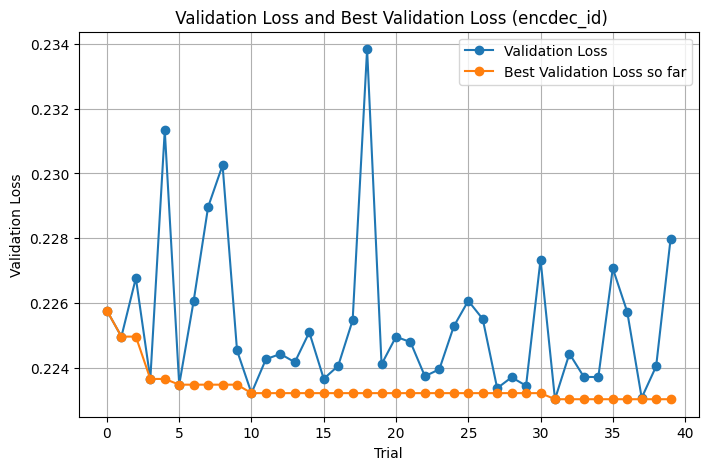

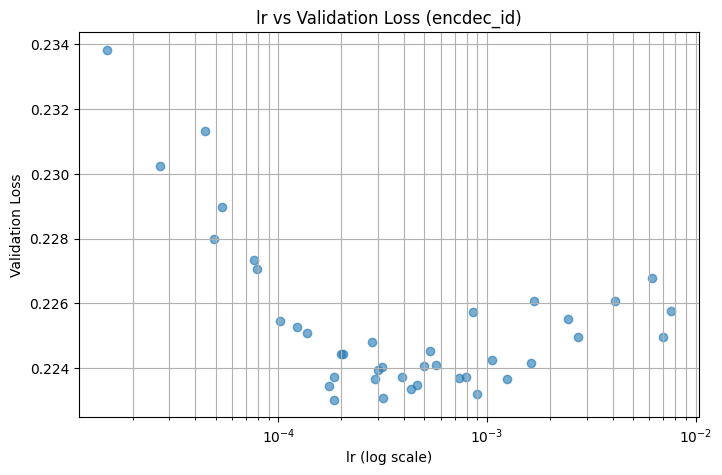

In [65]:
visualization.study_plots(study_encdec_id, title_prefix="encdec_id")

We again see a good behavior of the optimization history plot.

In [54]:
# Save study for if we want to train the model at a later time

save_dir = "../model_data/Encoder_decoder/"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(study_encdec_id, os.path.join(save_dir, "checkpoint_study_encdec_id.pkl"))

['../model_data/Encoder_decoder/checkpoint_study_encdec_id.pkl']

In [51]:
# Training using optimal hyperparameters

best_trial_encdec_id = study_encdec_id.best_trial
model_encdec_id = define_model_encdec_id(optuna.trial.FixedTrial(best_trial_encdec_id.params)).to(device)

optimizer = optim.AdamW(model_encdec_id.parameters(), 
                              lr=best_trial_encdec_id.params["lr"])
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode="min",factor=0.5,patience=5,min_lr=1e-7)

train_loss = []
val_loss = []

encdec__id_best_weights=training.reg_training_loop_rmspe(
    optimizer=optimizer,
    model=model_encdec_id,
    train_loader=train_loader,
    val_loader=test_loader,
    ot_steps=20,
    report_interval=5,
    n_epochs=200,
    list_train_loss=train_loss,
    list_val_loss=val_loss,
    device=device,
    eps=1e-8,
    scheduler=scheduler)

A new best validation loss at epoch  1  with validation loss of  tensor(0.2363, device='cuda:0') .
At  23.247890949249268  epoch  1 has training loss  tensor(0.2980, device='cuda:0')  and validation loss  tensor(0.2363, device='cuda:0') .

A new best validation loss at epoch  2  with validation loss of  tensor(0.2331, device='cuda:0') .
A new best validation loss at epoch  3  with validation loss of  tensor(0.2313, device='cuda:0') .
A new best validation loss at epoch  4  with validation loss of  tensor(0.2276, device='cuda:0') .
At  119.61778378486633  epoch  5 has training loss  tensor(0.2443, device='cuda:0')  and validation loss  tensor(0.2286, device='cuda:0') .

A new best validation loss at epoch  9  with validation loss of  tensor(0.2247, device='cuda:0') .
At  241.38564276695251  epoch  10 has training loss  tensor(0.2412, device='cuda:0')  and validation loss  tensor(0.2258, device='cuda:0') .

A new best validation loss at epoch  12  with validation loss of  tensor(0.2242, 

In [52]:
# Save model and study
model_io.save_model_and_study(
    model_encdec_id,
    study_encdec_id,
    save_dir="../model_data/Encoder_decoder",
    weights_filename="encdec_id_best_weights.pth",
    study_filename="encdec_id_study.pkl"
)

# model_encdec_id_loaded, study_encdec_id_loaded = model_io.load_model_and_study(
#     define_model_encdec_id,
#     device,
#     save_dir="../model_data/Encoder_decoder",
#     weights_filename="encdec_id_best_weights.pth",
#     study_filename="encdec_id_study.pkl"
# )

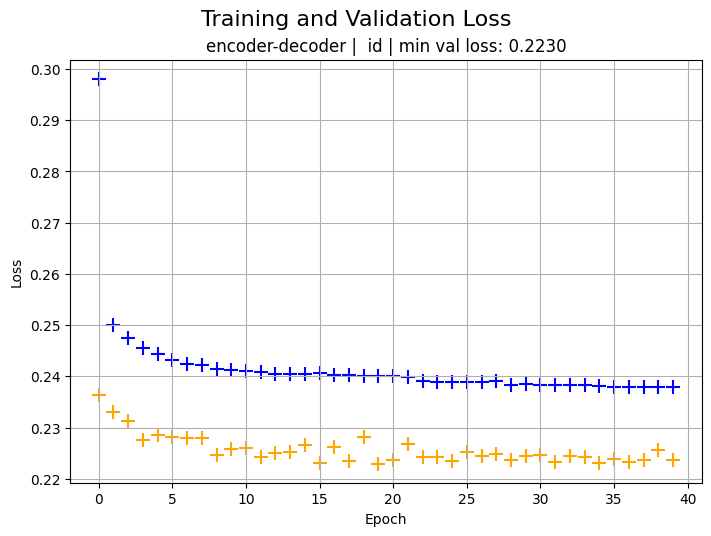

In [53]:
# Plots the loss and saves the plot
vis_dict={("encoder-decoder","id"):{"train_loss": train_loss,"val_loss": val_loss}}
visualization.training_plots(vis_dict, fig_width=7, save_path=save_dir+"encdec_id_loss.png")

In [55]:
# This is needed to be able to reproduce the plot of training and validation loss
torch.save((train_loss, val_loss), "../model_data/Encoder_decoder/encdec_id_loss.pt")

Final comments: 
- The optimization history in both cases look great.

- It is not trivial at all to initially suggest intervals for the parameters, though,
and that choice can radically change the behavior of the optimization or just make it fail. I struggled for a while.

- Yes, we did not beat the original minimum validation loss we got when running the model with a random guess of parameters (see notebook 'Decoder_transformer.ipynb').
However, the validation loss in the tuned version behaves BEATIFULLY! I think that tuning the transformer model is worth it.

### Stuff I don't want to delete just yet

In [ ]:
# Can this help with optuna optimization?

# sampler = optuna.samplers.TPESampler(
#     seed=42,
#     multivariate=True,      # model interactions
#     n_startup_trials=8,     # more random exploration up front
#     n_ei_candidates=64      # try more candidates each step
# )

In [ ]:
# Some legacy code (before creating external functions) just in case


# Save model and study

# save_dir = "../model_data/Encoder_decoder/"
# os.makedirs(save_dir, exist_ok=True)

# torch.save(model_encdec.state_dict(), os.path.join(save_dir, "encdec_best_weights.pth"))
# joblib.dump(study_encdec, os.path.join(save_dir, "encdec_study.pkl"))



# Load model and study and re-create model

# save_dir = "../model_data/Encoder_decoder/"

# study_encdec = joblib.load(os.path.join(save_dir, "encdec_study.pkl"))
# best_trial_encdec = study_encdec.best_trial


# model_encdec = define_model_encdec(optuna.trial.FixedTrial(best_trial_encdec.params)).to(device)
# state = torch.load(os.path.join(save_dir, "encdec_best_weights.pth"), map_location=device)
# model_encdec.load_state_dict(state)
# with io_utils.suppress_output():
#     model_encdec.eval()